In [1]:
import jax
import jax.numpy as np
import jraph
import flax.linen as nn
import numpy as onp
import matplotlib.pyplot as plt

from functools import partial

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../")

from models.gnn import GraphConvNet
from models.graph_utils import nearest_neighbors
from models.graph_utils import add_graphs_tuples

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-04-05 18:30:27.642922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/helmod/apps/centos7/Core/glib/2.56.1-fasrc01/lib64:/n/helmod/apps/centos7/Core/gcc/12.1.0-fasrc01/lib64:/n/helmod/apps/centos7/Core/gcc/12.1.0-fasrc01/lib:/n/helmod/apps/centos7/Core/mpc/1.2.1-fasrc01/lib64:/n/helmod/apps/centos7/Core/mpfr/4.1.0-fasrc01/lib64:/n/helmod/apps/centos7/Core/gmp/6.2.1-fasrc01/lib64:/n/helmod/apps/centos7/Core/cudnn/8.5.0.96_cuda11-fasrc01/lib:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/extras/CUPTI/lib64:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/lib64:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/lib
2023-04-05 18:30:27.643432: W tensorflow/compiler/xla/stream_executor/platform/defaul

In [4]:
n_nodes = 5000
x = np.load("/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/halos.npy")[:, :n_nodes,:]

In [5]:
sources, targets = jax.vmap(nearest_neighbors, in_axes=(0, None))(x[:4], 20)

## EGNN

In [6]:
from models.egnn import EGNN

In [11]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, x):
        model = jax.vmap(GraphConvNet(latent_size=100,
                                      num_mlp_layers=2,
                                      message_passing_steps=1,
                                      layer_norm=True,))
        return model(x)
    
model = GraphWrapper()
rng = jax.random.PRNGKey(42)

## Test equivariance

In [12]:
from models.graph_utils import rotate_representation

In [13]:
graph = jraph.GraphsTuple(
          n_node=np.array(4 * [[n_nodes]]), 
          n_edge=np.array(4 * [[20]]),
          nodes=x[:4, :, :], 
          edges=None,
          globals=np.ones((4, 7)),
          senders=sources,
          receivers=targets)

graph_out, _ = model.init_with_output(rng, graph)

x_out = graph_out.nodes

angle_deg = 45.
axis = np.array([0, 1 / np.sqrt(2), 1 / np.sqrt(2)])

x_out_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x_out, angle_deg, axis)

graph = jraph.GraphsTuple(
          n_node=np.array(4 * [[n_nodes]]), 
          n_edge=np.array(4 * [[20]]),
          nodes=jax.vmap(rotate_representation, in_axes=(0,None,None))(x[:4, :, :], angle_deg, axis),
          edges=None,
          globals=np.ones((4, 7)),
          senders=sources,
          receivers=targets)

graph_out, params = model.init_with_output(rng, graph)
x_out = graph_out.nodes

(5000, 100)
(5000, 100)


(array([8.000e+00, 9.000e+00, 6.000e+00, 3.976e+03, 8.540e+02, 5.200e+01,
        2.600e+01, 3.800e+01, 1.000e+00, 3.000e+01]),
 array([-0.51620436, -0.38137573, -0.24654709, -0.11171846,  0.02311018,
         0.15793881,  0.29276744,  0.42759606,  0.5624247 ,  0.69725335,
         0.832082  ], dtype=float32),
 <BarContainer object of 10 artists>)

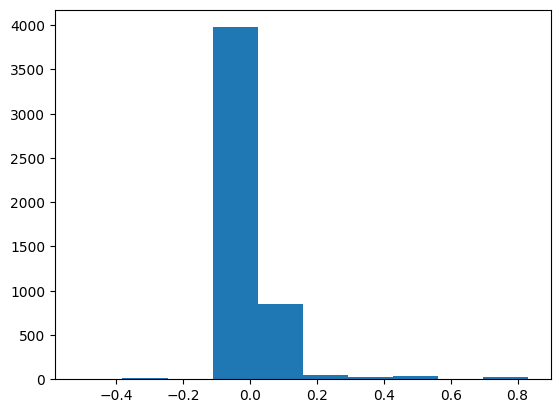

In [14]:
plt.hist(onp.array(x_out)[0,:,5])

In [31]:
# Equivariance ratio
eq_ratio = x_out / x_out_rot
print(eq_ratio.max(), eq_ratio.min(), eq_ratio)

1049.8004 -1190.6908 [[[ 0.2692127   0.45723802  1.2381907  ...  0.7974723   1.5413969
    1.        ]
  [ 0.2847087   0.15302382  1.2919043  ...  0.3543039   0.18256754
    1.        ]
  [ 0.28326762  0.19418299  1.2860186  ...  0.40629193  0.09079668
    1.        ]
  ...
  [ 0.26550445  0.79811376  1.1363125  ...  2.1283274   0.62427646
    1.        ]
  [ 0.232109    0.62853646  1.1878104  ...  1.4545578   0.84823734
    1.        ]
  [ 0.13474233  0.75180316  1.1338093  ...  1.913225    0.7989591
    1.        ]]

 [[ 0.284711    0.15302247  1.2919059  ...  0.354302    0.18258248
    1.        ]
  [ 0.284711    0.15302247  1.2919059  ...  0.354302    0.18258248
    1.        ]
  [ 0.284711    0.15302247  1.2919059  ...  0.354302    0.18258248
    1.        ]
  ...
  [ 0.24252038  0.7262987   1.1611135  ...  1.6940277   0.76813406
    1.        ]
  [ 0.16571589  0.8652308   1.0944163  ...  2.4114206   0.67684275
    1.        ]
  [ 0.1195629   0.78404444  1.1217417  ...  1.9985328 

In [489]:
sum(x.size for x in jax.tree_util.tree_leaves(params))

119316